In [4]:
"""
    Code for simultating the efficient frontier 
    of the Markowitz modelling approach.
"""

import errno
import os
import signal
import functools

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

In [5]:
def portfolio_variance(x, mtx_var_covar):
    """
        Portfolio Variance Function
    """
    variance = np.matmul(np.transpose(x), np.matmul(mtx_var_covar, x))
    return variance

In [6]:
ASSETS_COUNT = 2

In [7]:
plt.style.use("ggplot")

def createweightmatrix(asset_count):
    """
        Builds a set of porfolios 
    """
    lista1 = []

    for i in range(asset_count):
        lista0 = get_weights(asset_count)
        lista1.append(lista0)
    
    dataframe1 = pd.DataFrame(
                    lista1, 
                    columns=[ f'weigth_{i}' for i in range(1, asset_count + 1)] 
                )

 

    return dataframe1

def get_weights(n):
    """
        Returns a vector of size n, with weights, the sum should be 1.
    """

    search_space = np.linspace(0, 1, 1_000_000)
    cumulative_weights = 0
    vector_weight = []

    for i in range(n - 1):
        weight = np.random.choice(list(search_space)) ### uniform distribution.
        vector_weight.append(weight)
        cumulative_weights = cumulative_weights + weight
        search_space = np.linspace(0, 1 - cumulative_weights, 1_000_000)

    last_weight = 1 - cumulative_weights
    vector_weight.append(last_weight)
    return vector_weight

class TimeoutError(Exception):
    """
        Custom Exception.
    """
    pass

def timeout(seconds=15, error_message=os.strerror(errno.ETIME)):
    """
        timeout decorator.
    """
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wrapper

    return decorator

def list_wikipedia_sp500() -> pd.DataFrame:
    """
        Gets stocks that compound the S&P 500 index.
    """
    # Ref: https://stackoverflow.com/a/75845569/
    url = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies'
    return pd.read_html(url, attrs={'id': 'constituents'}, index_col='Symbol')[0]

In [6]:
df = list_wikipedia_sp500()

symbolslist = df.index.to_list()
symbolslist.remove("BRK.B")
symbolslist.remove("BF.B")
symbolslist.remove("AES")

symbolslist = symbolslist[3:ASSETS_COUNT + 2] + ['AAPL']

SPInfo = yf.download(symbolslist, start = '2021-01-01')

print("Data Downloadede Successfully!")

SPPrices = SPInfo.drop(["Open","Low","Close","High", "Volume"], axis = 1).fillna(.5)
returnslog = np.log(SPPrices)
compoundedreturns = returnslog.diff()

cretunrsmean = compoundedreturns.dropna().mean(axis=0)
cretunrsmeandf = cretunrsmean.to_frame()
expectedreturn = (np.exp(cretunrsmeandf)) - 1

mweights = createweightmatrix(ASSETS_COUNT)

expectedreturn = expectedreturn.rename(
    {0: 'expected return per stock'}, 
    axis=1
)

highexreturn = expectedreturn['expected return per stock']
highexreturn = pd.DataFrame(highexreturn,columns = ['expected return per stock'])

[*********************100%%**********************]  2 of 2 completed
Data Downloadede Successfully!


In [7]:
covreturns = compoundedreturns.cov()

In [15]:
x0 = [1 / len(symbolslist)] * len(symbolslist)

In [42]:
returns = np.array(highexreturn['expected return per stock'])
mtx_var_covar = np.array(covreturns)

def return_weights(target_return):

    non_negative = [(0, None) for i in range(len(symbolslist))]

    # constraints and boundary conditions for the optimiser
    l1_norm = [{"type": "eq", "fun": lambda x: sum(abs(x)) - 1}] # unitary in norm L1
    l2_norm = [{"type": "eq", "fun": lambda x: sum(x**2) - 1}] # unitary in norm L2
    markowitz = [{"type": "eq", "fun": lambda x: returns.dot(x) - target_return}] 

    optimal_result = op.minimize(
        fun=portfolio_variance, 
        x0=x0,\
        args=(mtx_var_covar),\
        constraints=(l1_norm + markowitz),\
        bounds=non_negative,
        options={'maxiter': 5000}
    )

    return np.array(optimal_result.x)

In [48]:
target_returns = np.linspace(0, 1, 20)
weights = [
    return_weights(x) for x in target_returns
]
variances = [
    portfolio_variance(weight, mtx_var_covar) for weight in weights
]

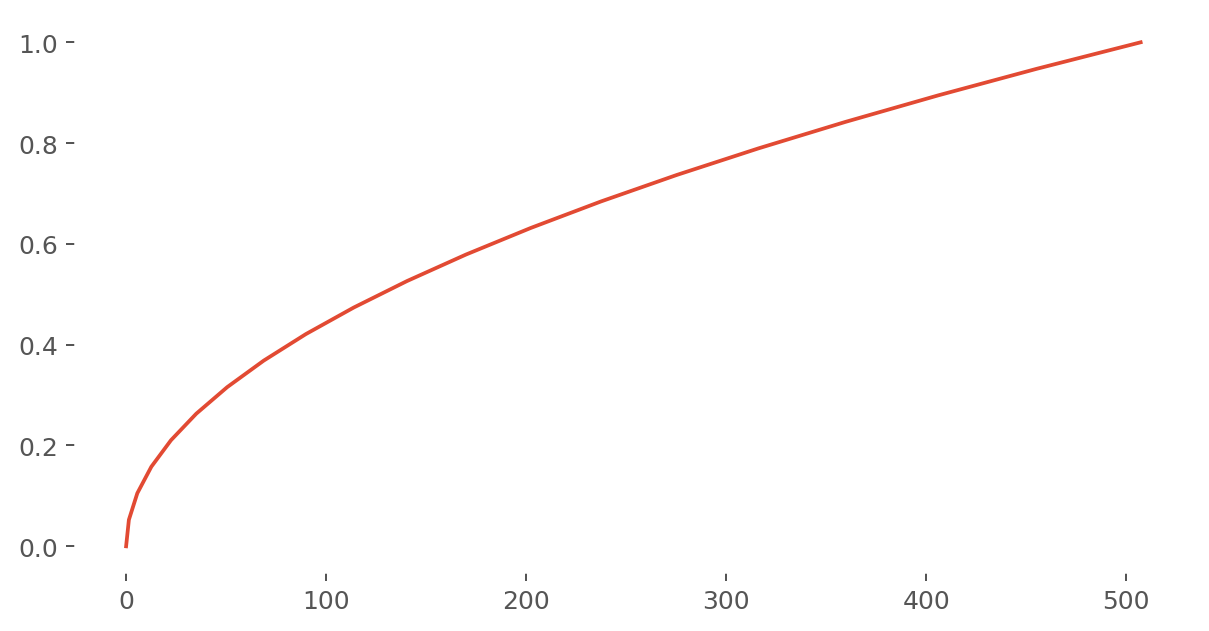

In [49]:
fig, ax = plt.subplots(
    figsize=(8, 4), dpi=180
)

ax.set_facecolor("white")

ax.plot(
    variances,
    target_returns
)

plt.show()